In [47]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import tqdm
import json
%matplotlib inline

from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

In [48]:
torch.manual_seed(42)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} will be used for training...")

cuda will be used for training...


In [50]:
train_data_path = os.path.join("..", "dataset", "data", "train")
valid_data_path = os.path.join("..", "dataset", "data", "valid")
test_data_path = os.path.join("..", "dataset", "data", "test")
print(f"Train path: {train_data_path}\nValid path: {valid_data_path}\nTrain Path: {train_data_path}")

Train path: ..\dataset\prototyping\train
Valid path: ..\dataset\prototyping\valid
Train Path: ..\dataset\prototyping\train


# 1. Defining Transforms for Data Augumentation

In [51]:
image_size = 256
batch_size = 32

train_transforms = v2.Compose([
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(15),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [52]:
training_data = ImageFolder(train_data_path, transform=train_transforms)
valid_data = ImageFolder(valid_data_path, transform=test_transforms)
test_data = ImageFolder(test_data_path, transform=test_transforms)

In [53]:
def make_weights_for_balanced_classes(images, nclasses):
    # n_images = len(images)

    # print("Counting class frequencies", flush=True)
    # count_per_class = Counter(image_class for _, image_class in tqdm.tqdm(images))
    # print(f"Counts: {count_per_class}", flush=True)

    print("Calculating weights...", flush=True)
    weight_per_class = {0: 1.1948951686, 1: 6.1309635173}

    print("Assigning weights...", flush=True)
    weights = [weight_per_class[image_class] for _, image_class in tqdm.tqdm(images)]

    return weights

In [54]:
if os.path.exists("weights.json"):
    with open("weights.json", "r") as f:
        weights = json.load(f)["weights"]
else:
    weights = make_weights_for_balanced_classes(training_data, 2)

In [55]:
set(weights)

{1.1948951686, 6.1309635173}

In [56]:
if not os.path.exists("weights.json"):
    class_weights_path = "./weights.json"
    class_weights = {"weights": weights}

    with open(class_weights_path, "w") as file:
        json.dump(class_weights, file)

In [57]:
from torch.utils.data.sampler import WeightedRandomSampler

weights = torch.DoubleTensor(weights)
training_sampler = WeightedRandomSampler(weights, len(weights))

In [58]:
train_loader = DataLoader(training_data, batch_size=batch_size, sampler=training_sampler)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [59]:
idx_to_class = {v: k for k, v in training_data.class_to_idx.items()}
idx_to_class

{0: 'fake', 1: 'real'}

In [60]:
def display_image(img_tensor, title=None):
  image = img_tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image
  # image = image.clip(0, 1)

  if title:
    plt.title(title)

  plt.imshow(image)
  plt.show()

def plot_double_line(x, y1, y2, title="", y1label="", y2label="", xlab="", ylab=""):
  plt.plot(x, y1, label=y1label)
  plt.plot(x, y2, label=y2label)

  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.legend()
  plt.title(title)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5467936].


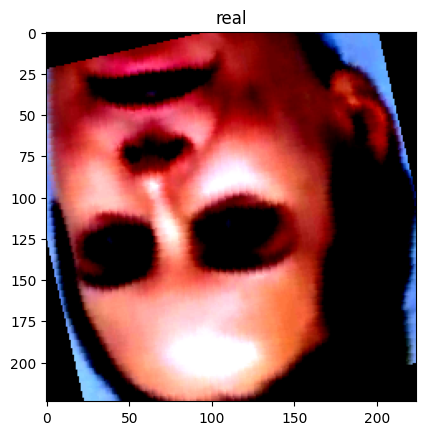

In [61]:
images, labels = next(iter(train_loader))
display_image(images[0], idx_to_class[labels[0].item()])

# Sample Images

In [101]:
from random import randint

def display_images(dataset, num_images=10, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4))  # Adjust figsize for better visualization
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spaces between the subplots
    fig.tight_layout()
    for i in range(num_images):
        image, label = dataset[randint(0, len(dataset) - 1)]
        image = image.permute(1, 2, 0).reshape(image.shape[1], image.shape[2], image.shape[0])
        ax = axes[i // cols, i % cols]  # Calculate row and column indices
        ax.imshow(image.squeeze(), cmap='gray')  # Squeeze to remove channel dimension
        ax.set_title(f"Label: {'Real' if label else 'Fake'}")  # Set title to the label
        ax.axis('off')  # Turn off axis for better visualization
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.611678].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.4373858].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..1.454815].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.367669].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5639184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3850

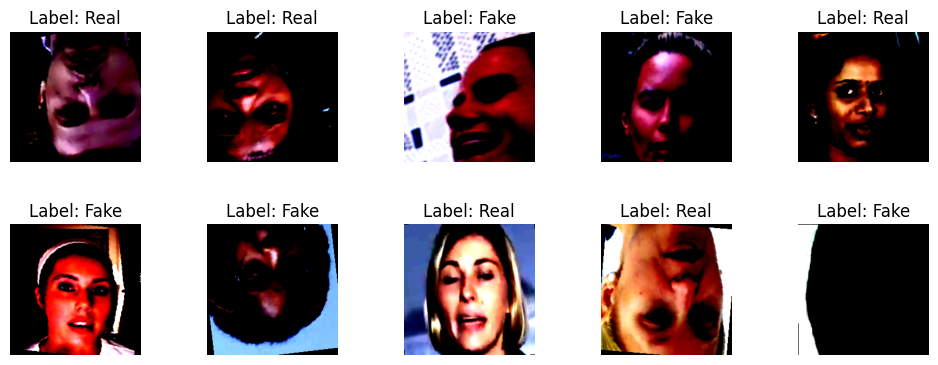

In [107]:
display_images(training_data)

In [62]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [63]:
# [I 2024-12-23 01:29:01,081] Trial 14 finished with value: 0.735 and parameters: {'n_layers': 2, 'learning_rate': 0.002571768221420213, 'dropout_rate': 0.18647655711328523, 'n_units_l0': 1216, 'n_units_l1': 2005}. Best is trial 14 with value: 0.735.
# for param in model.parameters():
#     param.requires_grad = False

dropout_rate = 0.18

# classifier = torch.nn.Sequential(
#     nn.Linear(512, 2),
#     nn.ReLU(),
#     nn.Dropout(p=dropout_rate),
#     nn.Linear(1024, 2),
#     # nn.ReLU(),
#     # nn.Dropout(p=dropout_rate),
#     # nn.Linear(2048, 2),
# )

classifier = nn.Linear(model.fc.in_features, 2)

model.fc = classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [64]:
if not os.path.exists("../checkpoints"):
    os.makedirs("../checkpoints")

In [65]:
latest_checkpoint_path = os.path.join("..", "checkpoints", "current_latest_model.pt")
best_checkpoint_path = os.path.join("..", "checkpoints", "current_best_model.pt")

# Loading the checkpoint and necessary stuff

In [66]:
checkpoint = None
if os.path.exists(latest_checkpoint_path):
    checkpoint = torch.load(latest_checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])
    print("Latest model loaded...")
    print(f"Epochs done: {checkpoint['number of epochs']}\nMinimum Validation Loss: {checkpoint['valid_loss']}")

# Hyper parameters

In [67]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.1948951686, 6.1309635173]).to(device))
epochs = 200
learning_rate = 0.001
validate_every = 2

In [68]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [69]:
running_loss_array = [] if not checkpoint else checkpoint["running_loss_array"]
valid_loss_array = [] if not checkpoint else checkpoint["valid_loss_array"]
epoch_array = [] if not checkpoint else checkpoint["epoch_array"]
start_epoch = 0 if not checkpoint else checkpoint["number of epochs"]

In [70]:
# from collections import Counter

# sampled_classes = []
# for i, (data, target) in enumerate(train_loader):
#     sampled_classes.extend(target.tolist())
#     if i > 100:
#         break

# print(Counter(sampled_classes))

EPOCH 1:


100%|██████████| 375/375 [01:04<00:00,  5.82it/s]


Epoch 1 :: Running Loss: 0.6931675831476848
EPOCH 2:


100%|██████████| 375/375 [00:50<00:00,  7.38it/s]


Epoch 2 :: Running Loss: 0.6759780085881552


100%|██████████| 7/7 [00:01<00:00,  6.83it/s]

EPOCH 2:
Running Loss = 0.6759780085881552	Validation Loss: 0.8081340193748474


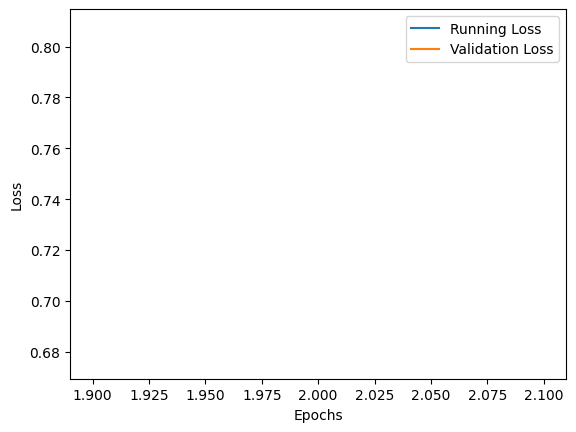

Minimum Validtion loss acquired, inf to 0.8081340193748474
EPOCH 3:


100%|██████████| 375/375 [00:50<00:00,  7.39it/s]


Epoch 3 :: Running Loss: 0.6746159551938374
EPOCH 4:


100%|██████████| 375/375 [00:50<00:00,  7.35it/s]


Epoch 4 :: Running Loss: 0.6804078734715779


100%|██████████| 7/7 [00:00<00:00,  8.78it/s]


EPOCH 4:
Running Loss = 0.6804078734715779	Validation Loss: 0.6484804664339338


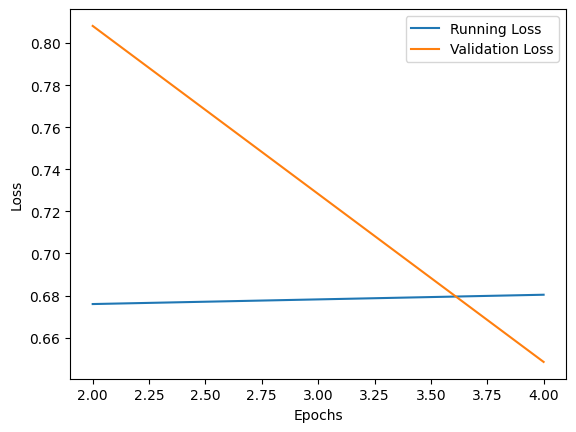

Minimum Validtion loss acquired, 0.8081340193748474 to 0.6484804664339338
EPOCH 5:


100%|██████████| 375/375 [00:51<00:00,  7.35it/s]


Epoch 5 :: Running Loss: 0.6717157587210337
EPOCH 6:


100%|██████████| 375/375 [00:51<00:00,  7.34it/s]


Epoch 6 :: Running Loss: 0.6635816787083944


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


EPOCH 6:
Running Loss = 0.6635816787083944	Validation Loss: 0.6561976160321917


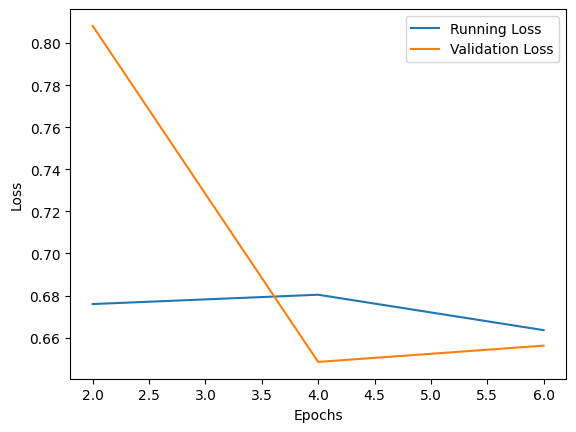

EPOCH 7:


100%|██████████| 375/375 [00:50<00:00,  7.40it/s]


Epoch 7 :: Running Loss: 0.6661367243131002
EPOCH 8:


100%|██████████| 375/375 [00:50<00:00,  7.41it/s]


Epoch 8 :: Running Loss: 0.6693938940366109


100%|██████████| 7/7 [00:00<00:00,  8.95it/s]


EPOCH 8:
Running Loss = 0.6693938940366109	Validation Loss: 0.6233592799731663


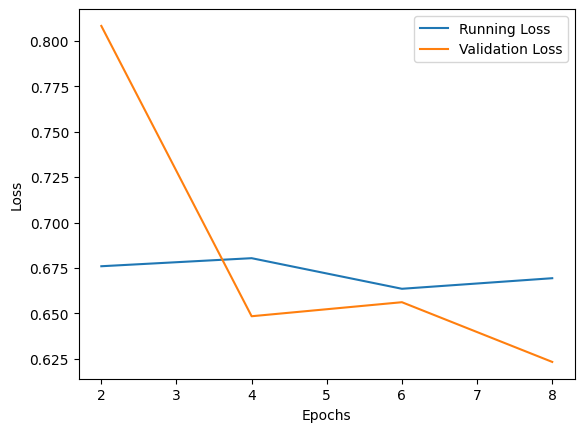

Minimum Validtion loss acquired, 0.6484804664339338 to 0.6233592799731663
EPOCH 9:


100%|██████████| 375/375 [00:51<00:00,  7.32it/s]


Epoch 9 :: Running Loss: 0.6653681478500366
EPOCH 10:


100%|██████████| 375/375 [00:51<00:00,  7.33it/s]


Epoch 10 :: Running Loss: 0.6607440633773803


100%|██████████| 7/7 [00:00<00:00,  8.71it/s]


EPOCH 10:
Running Loss = 0.6607440633773803	Validation Loss: 0.6218803695269993


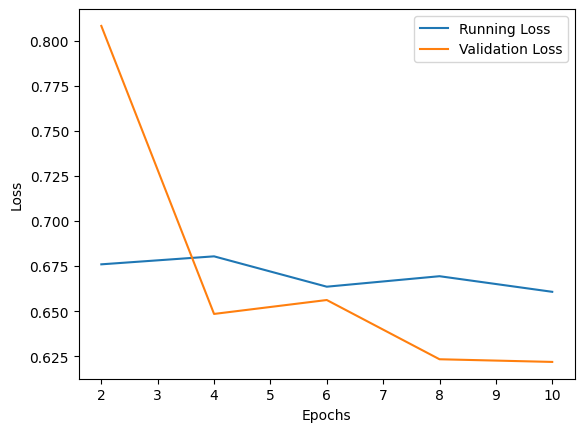

Minimum Validtion loss acquired, 0.6233592799731663 to 0.6218803695269993
EPOCH 11:


100%|██████████| 375/375 [00:50<00:00,  7.38it/s]


Epoch 11 :: Running Loss: 0.6663669918378194
EPOCH 12:


100%|██████████| 375/375 [00:51<00:00,  7.31it/s]


Epoch 12 :: Running Loss: 0.6644143410523733


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


EPOCH 12:
Running Loss = 0.6644143410523733	Validation Loss: 0.6605990018163409


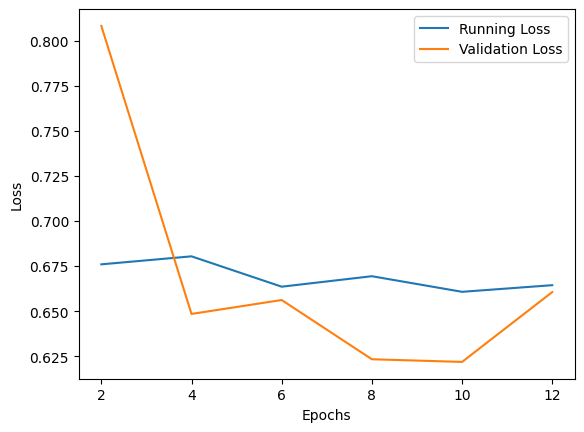

EPOCH 13:


100%|██████████| 375/375 [00:50<00:00,  7.38it/s]


Epoch 13 :: Running Loss: 0.6666779597600301
EPOCH 14:


100%|██████████| 375/375 [00:50<00:00,  7.41it/s]


Epoch 14 :: Running Loss: 0.6741747012138367


100%|██████████| 7/7 [00:00<00:00,  8.51it/s]


EPOCH 14:
Running Loss = 0.6741747012138367	Validation Loss: 0.6809260760034833


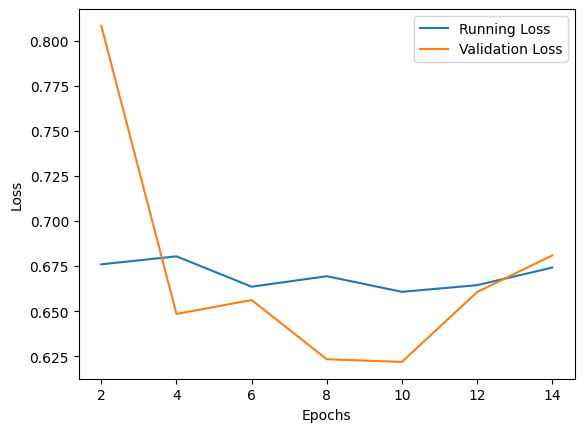

EPOCH 15:


100%|██████████| 375/375 [00:50<00:00,  7.38it/s]


Epoch 15 :: Running Loss: 0.6652691113948822
EPOCH 16:


100%|██████████| 375/375 [00:50<00:00,  7.43it/s]


Epoch 16 :: Running Loss: 0.6723178596496582


100%|██████████| 7/7 [00:00<00:00,  8.83it/s]


EPOCH 16:
Running Loss = 0.6723178596496582	Validation Loss: 0.6501400641032627


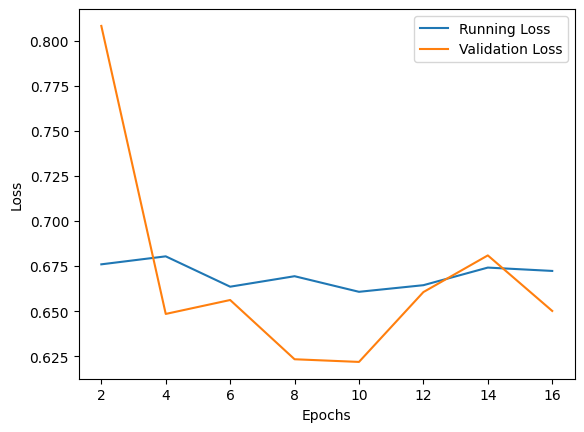

EPOCH 17:


100%|██████████| 375/375 [00:54<00:00,  6.92it/s]


Epoch 17 :: Running Loss: 0.6678266911506653
EPOCH 18:


100%|██████████| 375/375 [01:00<00:00,  6.17it/s]


Epoch 18 :: Running Loss: 0.6633431344032288


100%|██████████| 7/7 [00:00<00:00,  7.91it/s]

EPOCH 18:
Running Loss = 0.6633431344032288	Validation Loss: 0.6336486850466047


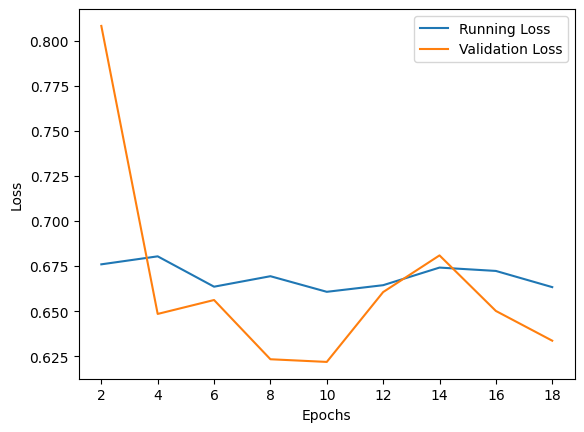

EPOCH 19:


 47%|████▋     | 175/375 [00:24<00:27,  7.16it/s]


KeyboardInterrupt: 

In [71]:
validation_loss_min = np.inf if not checkpoint else checkpoint["valid_loss"]
model.to(device)
model.train()

for e in range(start_epoch, epochs):
  running_loss = 0

  print(f"EPOCH {e + 1}:")
  i = 0
  for images, labels in tqdm.tqdm(train_loader):
    i += 1
    # print(f"{i} / {len(train_loader)} image being used for training")
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model.forward(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {e + 1} :: Running Loss: {running_loss / len(train_loader)}")

  current_model_state = {
    "state_dict": model.state_dict(),
    "valid_loss": validation_loss_min,
    "running_loss_array": running_loss_array,
    "valid_loss_array": valid_loss_array,
    "epoch_array": epoch_array,
    "number of epochs": e + 1,
  }

  validation_loss = 0

  if (e + 1) % validate_every == 0:
    epoch_array.append(e + 1)

    with torch.no_grad():
      model.eval()

      for images, labels in tqdm.tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        logps = model.forward(images)
        loss = criterion(logps, labels)

        validation_loss += loss.item()

    model.train()

    running_loss /= len(train_loader)
    validation_loss /= len(valid_loader)
    
    running_loss_array.append(running_loss)
    valid_loss_array.append(validation_loss)

    print(f"EPOCH {e + 1}:")
    print(f"Running Loss = {running_loss}\tValidation Loss: {validation_loss}")

    plot_double_line(epoch_array, running_loss_array, valid_loss_array, y1label="Running Loss", y2label="Validation Loss", xlab="Epochs", ylab="Loss")

    if validation_loss <= validation_loss_min:
      print(f"Minimum Validtion loss acquired, {validation_loss_min} to {validation_loss}")
      validation_loss_min = validation_loss
      current_model_state["valid_loss"] = validation_loss_min 
      torch.save(current_model_state, best_checkpoint_path)
  
  torch.save(current_model_state, latest_checkpoint_path)

# Metrics Calculation

In [66]:
validation_loss = 0
correct_valid = 0
total_valid = 0

with torch.no_grad():
    model.eval()

    for images, labels in tqdm.tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        logps = model.forward(images)
        loss = criterion(logps, labels)
        validation_loss += loss.item()

        # Calculate validation accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        correct_valid += (top_class == labels.view(*top_class.shape)).sum().item()
        total_valid += labels.size(0)

validation_loss /= len(valid_loader)
validation_accuracy = correct_valid / total_valid * 100

print("Validation Accuracy:", validation_accuracy)

100%|██████████| 410/410 [00:51<00:00,  7.90it/s]

Validation Accuracy: 71.8339945071712


# Original Dataset Validation Accuracy

In [22]:
best_model_state = torch.load(latest_checkpoint_path)
model.load_state_dict(best_model_state["state_dict"])

C:\Users\navan\AppData\Local\Temp\ipykernel_7220\2102997454.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(latest_checkpoint_path)


<All keys matched successfully>

In [23]:
validation_loss = 0
correct_valid = 0
total_valid = 0

model.to(device)

with torch.no_grad():
    model.eval()

    try:
        for images, labels in tqdm.tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            logps = model.forward(images)
            loss = criterion(logps, labels)
            validation_loss += loss.item()

            # Calculate validation accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            correct_valid += (top_class == labels.view(*top_class.shape)).sum().item()
            total_valid += labels.size(0)
    except Exception as e:
        pass

validation_loss /= len(valid_loader)
validation_accuracy = correct_valid / total_valid * 100
model.train()

print("Test Accuracy:", validation_accuracy)


100%|██████████| 96/96 [00:18<00:00,  5.25it/s]

Test Accuracy: 85.51432291666666


# Testing the model with images

In [41]:
from PIL import Image

In [44]:
image_path = r"..\dataset\prototyping\valid\real\valid_real_0010329.png"
image = Image.open(image_path).convert("RGB")
input_tensor = test_transforms(image).unsqueeze(0)

model.to(device)
model.eval()
input_tensor = input_tensor.to(device)

with torch.no_grad():
    output = model(input_tensor)

model.train()
output = torch.exp(output)
print("Output:", output)
predicted_class = torch.argmax(output, dim=1)
prediction = predicted_class.item()
print("Prediction:", idx_to_class[prediction])

Output: tensor([[ 0.0389, 24.7708]], device='cuda:0')
Prediction: real


# Model Parameter Counting

In [24]:
total_params = sum(p.numel() for p in model.parameters())
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params}\nTotal Trainable Parameters: {total_trainable_params}")

Total Parameters: 11177538
Total Trainable Parameters: 11177538


In [25]:
total_fc_params = sum(p.numel() for p in model.fc.parameters())
total_fc_trainable_params = sum(p.numel() for p in model.fc.parameters() if p.requires_grad)
print(f"Total FC Parameters: {total_fc_params}\nTotal FC Trainable Parameters: {total_fc_trainable_params}")

Total FC Parameters: 1026
Total FC Trainable Parameters: 1026


In [26]:
total_resnet_params = total_params - total_fc_params
total_resnet_trainable_params = total_trainable_params - total_fc_trainable_params
print(f"Total ResNet Parameters: {total_resnet_params}\nTotal ResNet Trainable Parameters: {total_resnet_trainable_params}")

Total ResNet Parameters: 11176512
Total ResNet Trainable Parameters: 11176512
